## Summary 

Author: Trenton Bricken

Computing circle intersections used in the Paper and fitting them using log linear regression to show how they are approximately exponential and relate to the softmax.  

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
from scipy.sparse import csc_matrix, coo_matrix, csr_matrix
import pandas as pd
from scipy.integrate import quad
import time

In [2]:
from SDM_Circ_Inter_Funcs import *
from Data_Processing_Associative_Memory import *
from Implementations_Associative_Memory import softmax

# Computing circle intersections used in the Paper. 

## Unnormalized log as a fraction $p$ of the whole vector space

/Users/trentonbricken/SDM/SDM_Circ_Inter_Funcs.py:292: RuntimeWarning: divide by zero encountered in log
  expected_intersect = perc_addresses_w_neurons + np.log(possible_addresses)


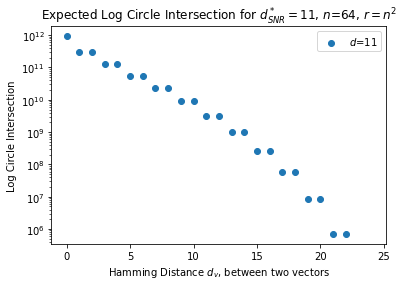

In [3]:
n=64
hamm_distances = [11]#space_frac_to_hamm_dist(n, space_frac_rang)
r = 2**n#1 #1000000 # number of neurons

# whether to enforce a neuron limit or have r = 2^n
hard_mem_places = False

for hamm_dist in hamm_distances:
    
    # circles that have centers at all distances within this given range. 
    circle_center_distances = np.arange(0,(2*hamm_dist)+3,1).astype(int)
    res = expected_intersection_interpretable(n, circle_center_distances, hamm_dist, r)
    res = np.asarray(res)
    plt.scatter(circle_center_distances, res, label="$d$="+str(hamm_dist))
    
#plt.plot(circle_center_distances, np.exp( (n//2)-1-circle_center_distances), label='exp') # need to flip so its a decay
plt.legend()
plt.yscale('log')
plt.xlabel('Hamming Distance $d_v$, between two vectors')
plt.ylabel('Log Circle Intersection')
plt.title("Expected Log Circle Intersection for $d^*_{SNR}=$"+str(hamm_dist)+", $n$="+str(n)+", $r=n^2$")
plt.gcf().savefig('figures/UnnormalizedCircleInterWeights_Log.png', dpi=250)
plt.show()

## Plots for circle intersection and the learnt $\beta$ approximation

/home/trenton/SDM/SDM_Circ_Inter_Funcs.py:292: RuntimeWarning: divide by zero encountered in log
  expected_intersect = perc_addresses_w_neurons + np.log(possible_addresses)
/home/trenton/SDM/SDM_Circ_Inter_Funcs.py:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(beta*xvals)


final loss 0.00016556675836909562
final loss 1.4748665080333012e-06
binary and cont betas 35.48476174346817 71.7092092212466
binary and cont softmax betas 43.738346099853516 69.15979766845703


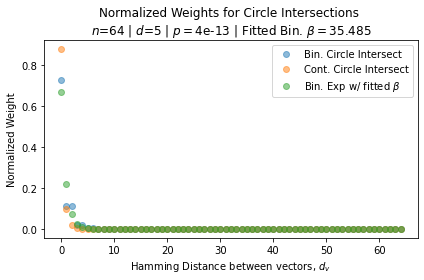

final loss 0.00018407184688840061
final loss 2.5343906600028276e-05
binary and cont betas 20.040984673242452 29.767091221988935
binary and cont softmax betas 24.5933780670166 34.28351974487305


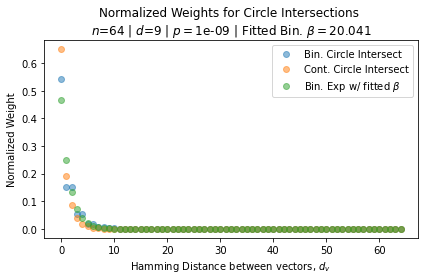

final loss 0.0001538475917186588


KeyboardInterrupt: 

In [6]:
nvals = [64, 100,784, 1000] #784 for MNIST
space_frac_rang = [4*(10**(-13)), 0.000000001, 0.00000001, 0.00001, 0.00037, 0.001, 0.1]
hamm_distances = []

fit_to_curve = True # only fit to the actual part of the circle intersection. 
attention_params = True  
normalize=True # if False should really be using the bias term too so everything 
# is on the correct scale

# able to generate lots of different types of plots here. 
types_to_plot = 'combo' #'binary', 'continuous', 'combo', 'cont_bin_comp'

if attention_params: 
    r = 2**64
    n_points = 1024
else: # traditional SDM parameters
    r = 1000000 
    n_points = 100 
    
for use_log in [False, True]:
    if use_log: 
        constrain_xax = True
    else: 
        constrain_xax = False
    for n in nvals: 
        hamm_distances = space_frac_to_hamm_radius(n, space_frac_rang)
        
        dvs = np.linspace(0,n,n_points).astype(int)
        dvs = np.unique(dvs)
        cs_v = hamm_to_cosine(dvs,n) # for the softmax
        cont_cs_v = np.copy(cs_v)
        cont_cs_v[0] = cont_cs_v[0] - 1e-15
        assert cont_cs_v[0] != 'should not be 1 else will throw a division error in the equation.'
            
        for ind, hamm_dist in enumerate(hamm_distances): 
            
            res = expected_intersection_interpretable(n, dvs, hamm_dist, r)
            res = np.nan_to_num(res, nan=0.0)

            cap_res = cap_intersection(n, cont_cs_v, hamm_dist, r)
            cap_res = np.nan_to_num(cap_res, nan=0.0)

            chop_ind = int( (hamm_dist)//(n/len(dvs)) )

            chopped_dvs = dvs[:chop_ind]
            chopped_cs_v = cs_v[:chop_ind]
            chopped_res = res[:chop_ind]
            chopped_cont_cs_v = cont_cs_v[:chop_ind] # intersect falls off at one value closer.
            chopped_cap_res = cap_res[:chop_ind]

            #print('chop ind and its success', chop_ind, res[:chop_ind+1], cap_res[:chop_ind])

            assert (chopped_res<=0.0).sum()==0, "Chopped ind is incorrect"
            assert (chopped_cap_res<=0.0).sum()==0, "Chopped ind is incorrect"

            bin_beta,bin_bias = fit_beta_regression(n, chopped_cs_v, chopped_res, return_bias=True, ham_input=False )
            cap_beta,cap_bias = fit_beta_regression(n, chopped_cont_cs_v, chopped_cap_res, return_bias=True, ham_input=False)

            # gold standard softmax fit: 
            bin_sm_beta = fit_softmax_backprop(n, cs_v, res, ham_input=False, plot_losses=False)
            cap_sm_beta = fit_softmax_backprop(n, cont_cs_v, cap_res, ham_input=False, plot_losses=False)
            print('binary and cont betas', bin_beta, cap_beta)
            print("binary and cont softmax betas", bin_sm_beta, cap_sm_beta)

            if types_to_plot == 'binary':
                plabels = ['Circle Intersection', 'Softmax w/ fitted '+ r'$\beta$']#['Bin. Circle Intersect','Bin. Exp w/ fitted '+ r'$\beta$']
                pvals =[res, bin_beta]
                beta_postfix = " | Fitted "+r'$\beta=$'+str(round(bin_beta,3))
            elif types_to_plot == 'continuous':
                plabels = ['Cont. Circle Intersect','Cont. Exp w/ fitted '+ r'$\beta$']
                pvals = [cap_res, cap_beta]
                beta_postfix = " | Fitted "+r'$\beta=$'+str(round(cap_beta,3))
            elif types_to_plot == 'cont_bin_comp':
                # compare continuous to binary circle intersections
                plabels = ['Bin. Circle Intersect','Cont. Circle Intersect']
                pvals = [res, cap_res]
                beta_postfix = ''
            elif types_to_plot=='combo': 
                plabels = ['Bin. Circle Intersect', 'Cont. Circle Intersect', 
                           'Bin. Exp w/ fitted '+ r'$\beta$', 
                           ]
                pvals = [res, cap_res, bin_beta]
                beta_postfix = " | Fitted Bin. "+r'$\beta=$'+str(round(bin_beta,3))
            elif types_to_plot=='all': 
                plabels = ['Bin. Circle Intersect', 'Cont. Circle Intersect', 
                           'Bin. Exp w/ fitted '+ r'$\beta$', 
                           'Cont. Exp w/ fitted '+ r'$\beta$']
                pvals = [res, cap_res, bin_beta, cap_beta]
                beta_postfix = " | Fitted Bin. "+r'$\beta=$'+str(round(bin_beta,3)) + " | Fitted Cont. "+r'$\beta=$'+str(round(cap_beta,3))
            for label, vals in zip(plabels, pvals):
                if normalize: 
                    if "Intersect" in label: 
                        toplot = vals/sum(vals)
                    elif "fitted" in label:
                        toplot = softmax(cs_v, vals)
                else: 
                    if "Intersect" in label: 
                        toplot = vals
                    elif "fitted" in label:
                        toplot = np.exp(cs_v*vals) # vals is beta here. 
                    else: 
                        raise Exception("Need to ensure labels are being used")

                #if use_log and hamm_dist<10:
                #    plt.scatter(dvs[:chop_ind*2+5], toplot[:chop_ind*2+5], label=label, alpha=0.5)
                if constrain_xax: 
                    plt.scatter(dvs[:chop_ind*2 +5], toplot[:chop_ind*2 +5], label=label, alpha=0.5)
                else: 
                    plt.scatter(dvs, toplot, label=label, alpha=0.5)

            if use_log:
                plt.yscale('log')
                text_prefix = "Log "
            else: 
                text_prefix = ""
                plt.legend()
                #plt.xlim([-0.1, chop_ind+10])
                #print('learned softmax beta vs attention beta:', bin_beta, 1/np.sqrt(n))
                plt.xlabel('Hamming Distance between vectors, $d_v$')
            
            if normalize: 
                plt.ylabel(text_prefix+'Normalized Weight')
                if not use_log: 
                    plt.title(text_prefix+"Normalized Weights for Circle Intersections \n"+"$n$="+str(n)+" | $d$="+str(hamm_dist)+" | $p=$"+str(space_frac_rang[ind])+beta_postfix)
            else: 
                plt.ylabel(text_prefix+'Circle Intersection')
                if not use_log: 
                    plt.title(text_prefix+"Expected Circle Intersections \n"+"$n$="+str(n)+" | $d$="+str(hamm_dist)+" | $p=$"+str(space_frac_rang[ind])+beta_postfix)
            #plt.xlim([-1,chop_ind*2 +15])
            plt.tight_layout()
            # MAKE SURE I UPDATE FOR WHAT KIND OF PLOT IS BEING MADE HERE. 
            plt.gcf().savefig('figures/SoftmaxComparison/SoftmaxComparison_'+types_to_plot+'_AttentionParams'+str(attention_params)+"normalized"+str(normalize)+"Logged="+str(use_log)+"N="+str(n)+'_'+str(hamm_dist)+'.png', dpi=250)
            plt.show()
            #break 
        #break 
    #break 

# Debugging Scripts

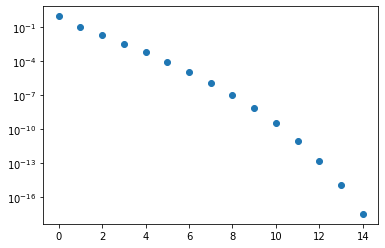

In [46]:
cut_ind = 15
plt.scatter(dvs[:cut_ind], toplot[:cut_ind], label=label, alpha=1.0)
#plt.ylim([min(toplot[:cut_ind])-0.01,max(toplot[:cut_ind])])
plt.yscale('log')


In [35]:
toplot

array([8.81538559e-01, 9.59074557e-02, 1.84030366e-02, 3.45231567e-03,
       5.94631641e-04, 9.07166121e-05, 1.18761106e-05, 1.28945071e-06,
       1.11499355e-07, 7.29612114e-09, 3.37820406e-10, 1.00953564e-11,
       1.70734749e-13, 1.34059963e-15, 3.55097285e-18, 1.80045498e-21,
       5.46932116e-26, 4.63202370e-33, 2.55221841e-49, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [3]:
n=64
r = 1000000 #2**64#1000000#2**64
n_points = 100 #1024#100#1024
hamm_dist = 11
rad = 1 # always unit norm due to L2 constraint.

Beta Fit MSE: 8505162610285.588
Beta Fit MSE: 2.079404098286369e+26
Beta Fit MSE: 6.290554047680983e+17
betas! 15.852765236405924 31.42300582303825 21.53974551313375


/Users/trentonbricken/SDM/SDM_Circ_Inter_Funcs.py:261: RuntimeWarning: divide by zero encountered in log
  expected_intersect = perc_addresses_w_neurons + np.log(possible_addresses)


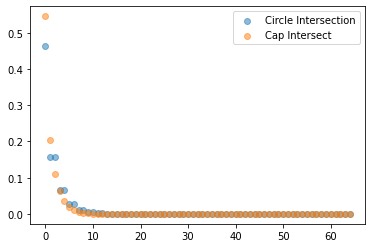

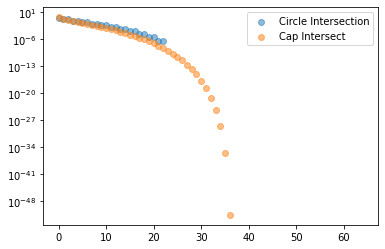

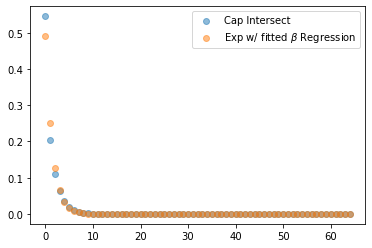

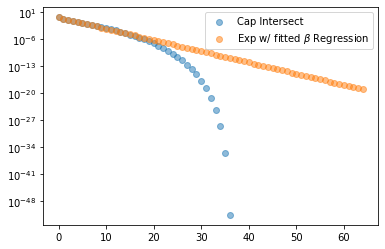

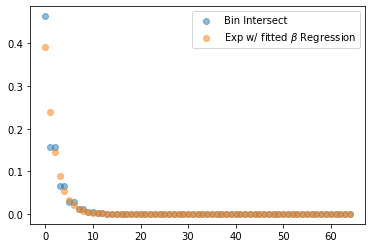

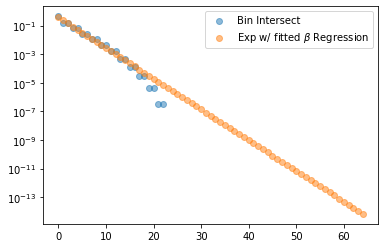

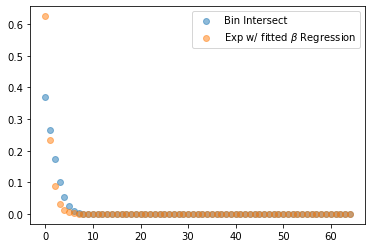

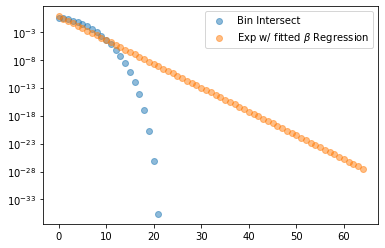

In [5]:
dvs = np.linspace(0,n,n_points).astype(int) #np.asarray([100,490,495,498,499,500,501,502,504,506,508]) #
dvs = np.unique(dvs)
cs_v = hamm_to_cosine(dvs,n) # for the softmax

chop_ind = int( (hamm_dist*2+1)//(n/len(dvs)) )
chopped_dvs = dvs[:chop_ind]
chopped_cs_v = cs_v[:chop_ind]

dvs = np.linspace(0,n,n_points).astype(int)
dvs = np.unique(dvs)
cs_v = hamm_to_cosine(dvs,n) # for the softmax
res = expected_intersection_interpretable(n, dvs, hamm_dist, r)
res = np.nan_to_num(res, nan=0.0)

cont_cs_v = np.copy(cs_v)
cont_cs_v[0] = cont_cs_v[0] - 1e-15
assert cont_cs_v[0] != 'should not be 1 else will throw a division error in the equation.'
cont_res = sphere_continuous_space_intersection( n, cont_cs_v, hamm_dist, ham_input=False)

cap_res = cap_intersection(n, cont_cs_v, hamm_dist)
cap_res = np.nan_to_num(cap_res, nan=0.0)

chop_ind = int( (hamm_dist)//(n/len(dvs)) )

chopped_dvs = dvs[:chop_ind]
chopped_cs_v = cs_v[:chop_ind]
chopped_res = res[:chop_ind]

chopped_cont_cs_v = cont_cs_v[:chop_ind] # intersect falls off at one value closer.
chopped_cont_res = cont_res[:chop_ind]
chopped_cap_res = cap_res[:chop_ind]
#print('chop ind and its success', chop_ind, res[:chop_ind+1], cont_res[:chop_ind], cap_res[:chop_ind+1])

assert (chopped_res<=0.0).sum()==0, "Chopped ind is incorrect"
assert (chopped_cont_res<=0.0).sum()==0, "Chopped ind is incorrect"

bin_beta,bin_bias = fit_beta_regression(n, chopped_cs_v, chopped_res, return_bias=True, ham_input=False )
cont_beta,cont_bias = fit_beta_regression(n, chopped_cont_cs_v, chopped_cont_res, return_bias=True, ham_input=False)
        
cap_beta,cap_bias = fit_beta_regression(n, chopped_cont_cs_v, chopped_cap_res, return_bias=True, ham_input=False)
print('betas!', bin_beta, cont_beta, cap_beta)
plt.scatter(dvs, res/sum(res), label='Circle Intersection', alpha=0.5)
#plt.scatter(dvs, cont_res/sum(cont_res), label="Cont. Intersect", alpha=0.5)
plt.scatter(dvs, cap_res/sum(cap_res), label="Cap Intersect", alpha=0.5)
plt.legend()
plt.show()

plt.scatter(dvs, res/sum(res), label='Circle Intersection', alpha=0.5)
#plt.scatter(dvs, cont_res/sum(cont_res), label="Cont. Intersect", alpha=0.5)
plt.scatter(dvs, cap_res/sum(cap_res), label="Cap Intersect", alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

plt.scatter(dvs, cap_res/sum(cap_res), label="Cap Intersect", alpha=0.5)
plt.scatter(dvs, softmax(cs_v, cap_beta), label="Exp w/ fitted "+ r"$\beta$", alpha=0.5)
plt.legend()
plt.show()

plt.scatter(dvs, cap_res/sum(cap_res), label="Cap Intersect", alpha=0.5)
plt.scatter(dvs, softmax(cs_v, cap_beta), label="Exp w/ fitted "+ r"$\beta$", alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

plt.scatter(dvs, res/sum(res), label="Bin Intersect", alpha=0.5)
plt.scatter(dvs, softmax(cs_v, bin_beta), label="Exp w/ fitted "+ r"$\beta$", alpha=0.5)
plt.legend()
plt.show()

plt.scatter(dvs, res/sum(res), label="Bin Intersect", alpha=0.5)
plt.scatter(dvs, softmax(cs_v, bin_beta), label="Exp w/ fitted "+ r"$\beta$", alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

plt.scatter(dvs, cont_res/sum(cont_res), label="Bin Intersect", alpha=0.5)
plt.scatter(dvs, softmax(cs_v, cont_beta), label="Exp w/ fitted "+ r"$\beta$", alpha=0.5)
plt.legend()
plt.show()

plt.scatter(dvs, cont_res/sum(cont_res), label="Bin Intersect", alpha=0.5)
plt.scatter(dvs, softmax(cs_v, cont_beta), label="Exp w/ fitted "+ r"$\beta$", alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()


## Relating Learnt Beta to Hamming distance and fraction of the space

MSE: 3358246186730.816
-19.3852613966758


/Users/trentonbricken/SDM/SDM_Circ_Inter_Funcs.py:122: RuntimeWarning: divide by zero encountered in log
  expected_intersect = perc_addresses_w_neurons + np.log(possible_addresses)


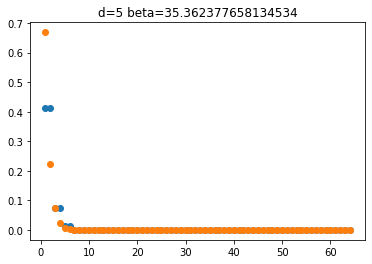

MSE: 494746754149237.3
-9.071061635465634


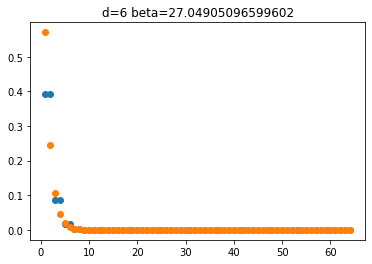

MSE: 4.917521770654703e+16
-5.584150365046185


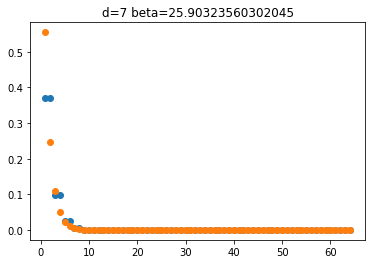

MSE: 3.4890719565688904e+18
0.7165150986722288


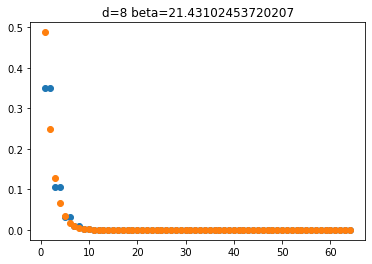

MSE: 1.8404013120007183e+20
4.070125546257721


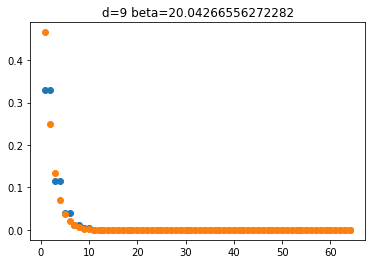

MSE: 7.446427397591388e+21
8.59109484471021


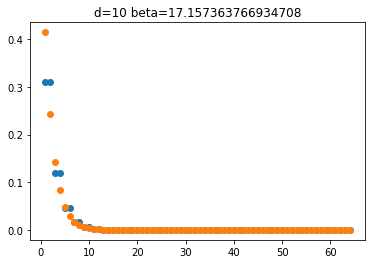

MSE: 2.368199684389012e+23
11.568590937189708


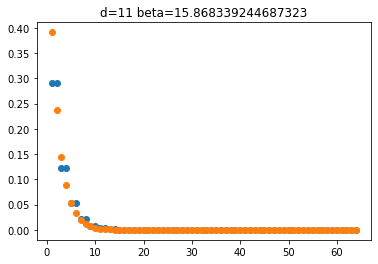

MSE: 6.039092380926927e+24
15.079182503182679


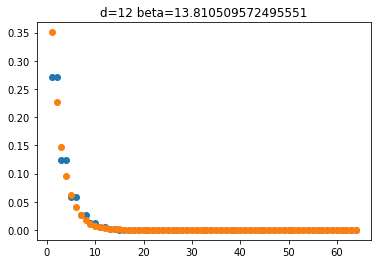

MSE: 1.2550915970382744e+26
17.68005507884874


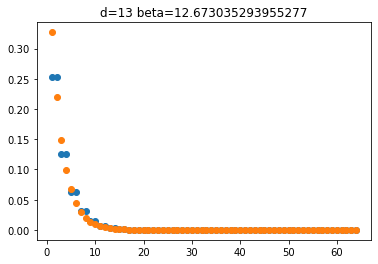

MSE: 2.1554369547290237e+27
20.523514600034638


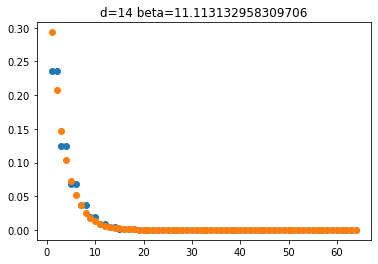

MSE: 3.0946263448293823e+28
22.784579330140105


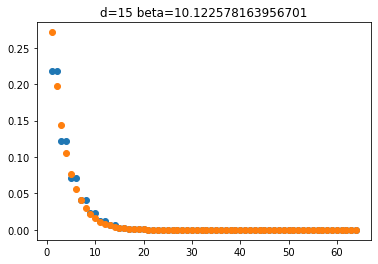

MSE: 3.75272591056551e+29
25.140684027063394


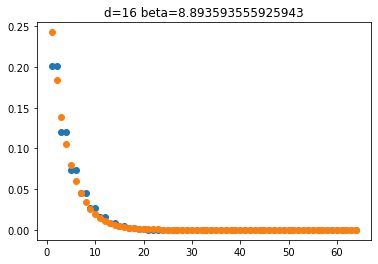

MSE: 3.877651538544868e+30
27.099380952540272


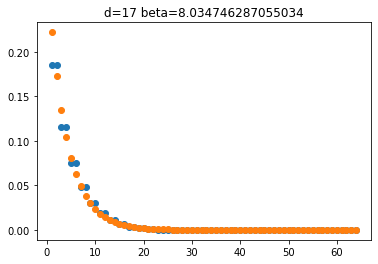

MSE: 3.4416616021751205e+31
29.07314768166922


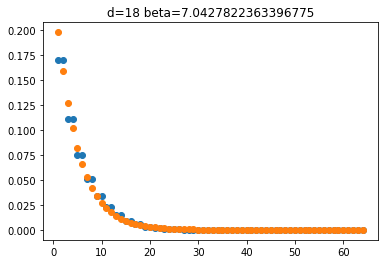

MSE: 2.642130321781819e+32
30.76095136828274


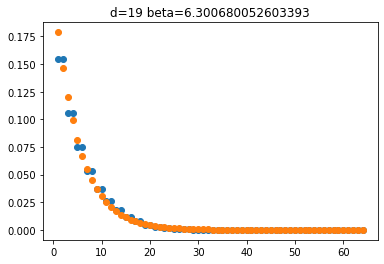

MSE: 1.766151473233366e+33
32.41877058848363


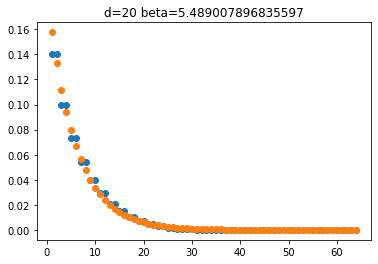

MSE: 1.033805863656846e+34
33.8610083766222


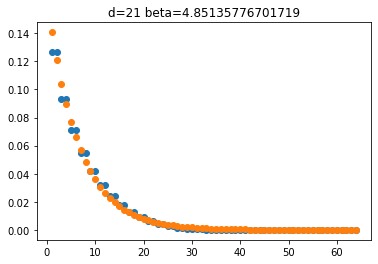

MSE: 5.33016141126881e+34
35.24749991422474


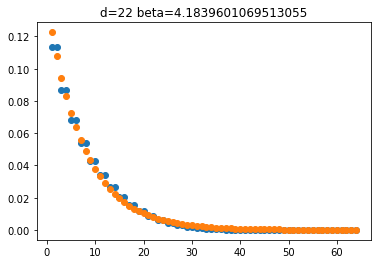

MSE: 2.4318948346450823e+35
36.4645102852391


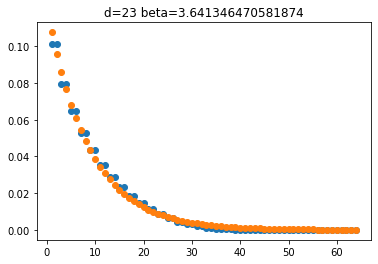

MSE: 9.872216280756693e+35
37.6113075532284


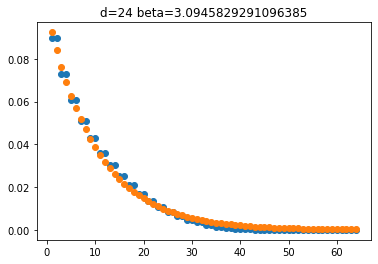

MSE: 3.578743367776027e+36
38.61979436703833


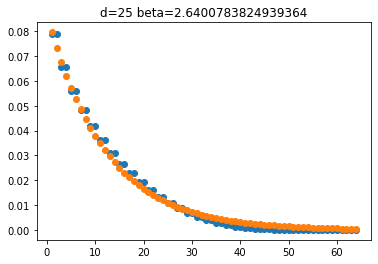

MSE: 1.1644337094787243e+37
39.55065610086857


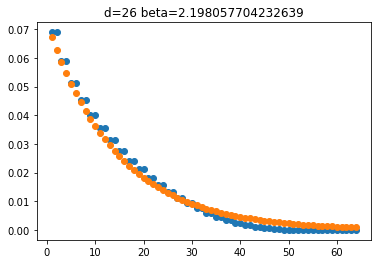

MSE: 3.4089558379416773e+37
40.36506763686691


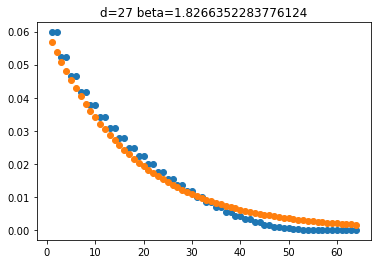

MSE: 9.021091500045557e+37
41.09930046460508


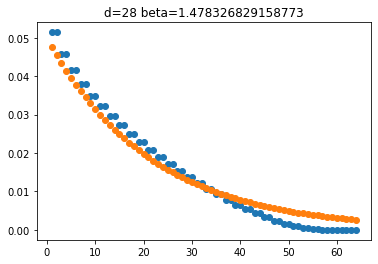

MSE: 2.1602128399158452e+38
41.733345162132316


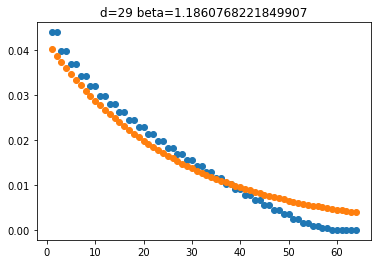

MSE: 4.699434005392256e+38
42.28857592625404


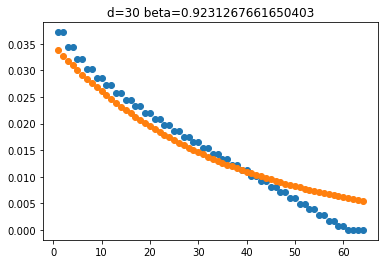

MSE: 9.291070613463979e+38
42.75707574079664


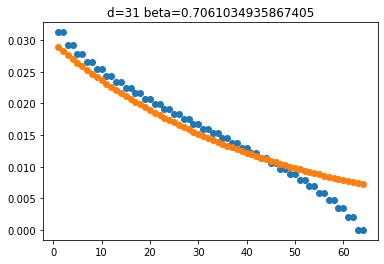

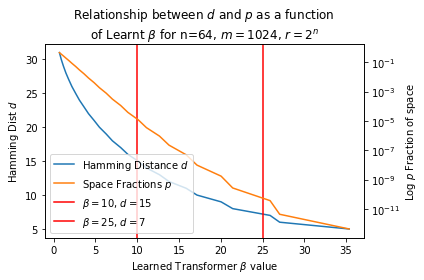

,0,1
0,5.0,35.362378
1,6.0,27.049051
2,7.0,25.903236
3,8.0,21.431025
4,9.0,20.042666
5,10.0,17.157364
6,11.0,15.868339
7,12.0,13.810510
8,13.0,12.673035
9,14.0,11.113133


In [34]:

n=64
d = np.arange(5,n//2).astype(int)
#space_frac_rang = [0.00000001, 0.00001, 0.001, 0.1]
dv = np.linspace(1,n, 1024).astype(int)
dv = np.unique(dv)
r = 2**n#256#1000000
#beta_d = -(n-2*d)**2 / 2
beta_cs = -(n-2*d)**2 / n
plot_fits = True
#plt.plot(d, beta_d)
#plt.show()
learned_betas = []
fit_to_curve = True
normalize=True
for hamm_dist in d: 
    res = expected_intersection_interpretable(n, dv, hamm_dist, r)    
    res = np.nan_to_num(res,nan=0.0)
    
    if fit_to_curve:
        # want to fit the regression to the circle intersection part
        # not to the whole circle intersect function
        chop_ind = int( (hamm_dist)//(n/len(dv)) )
        chopped_dvs = dv[:chop_ind]
        chopped_res = res[:chop_ind]
        fit_beta_res, beta = fit_beta_regression(n, chopped_dvs, chopped_res )
        cs_v = 1-(2*dv)/n
        print(bias)
        if normalize:
            fit_beta_res = softmax(cs_v, beta)
        else: 
            fit_beta_res = np.exp(beta*cs_v)*np.exp(bias)#softmax(cs_v, beta)
    else: 
        fit_beta_res, beta = fit_beta_regression(n, dv, res )
    
    #fit_beta_res, beta = fit_beta_regression(n, dv, res )
    
    if plot_fits:
        plt.figure()
        plt.scatter(dv,res/sum(res))
        plt.scatter(dv, fit_beta_res)
        plt.title('d='+str(hamm_dist)+" beta="+str(beta))
        plt.show()
    
    learned_betas.append(beta)
    
pvals = hamm_dist_to_space_frac(n, d)
    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
lns1 = ax1.plot(learned_betas, d, label=r"Hamming Distance $d$")
lns2 = ax2.plot(learned_betas, pvals, color='tab:orange', label='Space Fractions $p$')
lns3 = ax1.axvline(10, label=r"$\beta=10$, $d=15$", linestyle='solid',color='red')
lns4 = ax1.axvline(25, label=r"$\beta = 25$, $d=7$", linestyle='solid',color='red')

ax1.set_ylabel("Hamming Dist $d$")
ax1.set_xlabel(r"Learned Transformer $\beta$ value")#, color='g')
ax2.set_ylabel('Log $p$ Fraction of space')#, color='b')
ax2.set_yscale('log')

lns = lns1+lns2+[lns3] + [lns4]
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='lower left')

plt.title(r"Relationship between $d$ and $p$ as a function"+ "\n"+r"of Learnt $\beta$ for n="+str(n)+", $m=1024$, $r=2^n$")
plt.tight_layout()
plt.gcf().savefig('figures/Beta_d_p_relationships='+str(n)+'.png', dpi=250)
plt.show()
pd.DataFrame([d, learned_betas]).T

In [65]:
pvals

[4.5014084690611633e-13,
 4.514509480222501e-12,
 3.81907067277011e-11,
 1.771111690087537e-09,
 9.982491118931073e-09,
 2.2833053502227052e-07,
 9.404810782147002e-07,
 3.534743771272836e-06,
 3.866538440643517e-05,
 0.00011344119144164029,
 0.0007813946724140146,
 0.001844982138270023,
 0.008429095022140554,
 0.0163828795494116,
 0.029970594783499612,
 0.08432145571985172,
 0.13021773828832678,
 0.2661543880139208,
 0.35399037706738173,
 0.5496733768739839]

# Additional Plots not Used in the Paper

## Normalized Hamming distance plot. Uses vectors at possible d_v distance. 

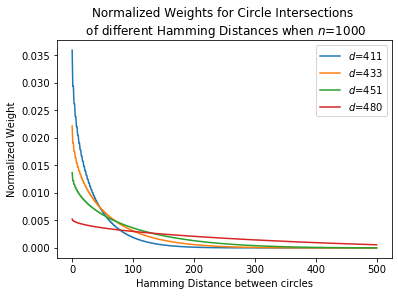

In [111]:
# portions of space within hamm_dist bits for: 0.00000001, 0.00001, 0.001, 0.1

space_frac_rang = [0.00000001, 0.00001, 0.001, 0.1]
n=1000
hamm_distances = space_frac_to_hamm_dist(n, space_frac_rang)
r = 1000000 # number of neurons

# whether to enforce a neuron limit or have r = 2^n
hard_mem_places = False

for hamm_dist in hamm_distances:
    
    # circles that have centers at all distances within this given range. 
    circle_center_distances = np.arange(0,n//2,1).astype(int) #np.arange(0,n//2,10).astype(int)
    res = expected_intersection_lune(n, circle_center_distances, hamm_dist, r)
    res = np.asarray(res)
    plt.plot(circle_center_distances, res/res.sum(), label="$d$="+str(hamm_dist))
    
plt.legend()
plt.xlabel('Hamming Distance between circles')
plt.ylabel('Normalized Weight')
plt.title("Normalized Weights for Circle Intersections \n of different Hamming Distances when $n$="+str(n))
plt.gcf().savefig('figures/CircleInterWeights.png', dpi=250)
plt.show()

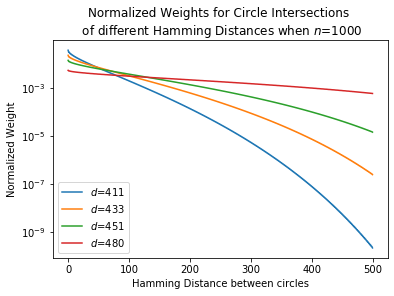

In [66]:
space_frac_rang = [0.00000001, 0.00001, 0.001, 0.1]
n=1000
hamm_distances = space_frac_to_hamm_dist(n, space_frac_rang)
r = 1000000 # number of neurons

# whether to enforce a neuron limit or have r = 2^n
hard_mem_places = False

for hamm_dist in hamm_distances:
    
    # circles that have centers at all distances within this given range. 
    circle_center_distances = np.arange(0,n//2,1).astype(int)
    
    res = expected_intersection_lune(n, circle_center_distances, hamm_dist, r)
        

    res = np.asarray(res)
    plt.plot(circle_center_distances, res/res.sum(), label="$d$="+str(hamm_dist))
    
plt.legend()
plt.xlabel('Hamming Distance between circles')
plt.ylabel('Normalized Weight')
plt.title("Normalized Weights for Circle Intersections \n of different Hamming Distances when $n$="+str(n))
plt.yscale('log')
plt.gcf().savefig('figures/CircleInterWeights_Log.png', dpi=250)
plt.show()

## Plotting with much smaller n=64 that is common in Transformer self Attention

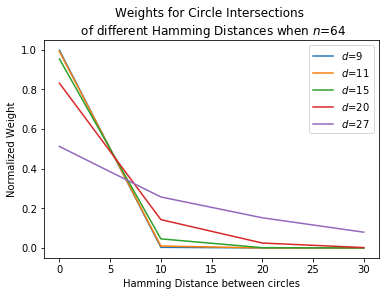

In [15]:
space_frac_rang = [0.000000001,0.00000001, 0.00001, 0.001, 0.1]
n=64
hamm_distances = space_frac_to_hamm_dist(n, space_frac_rang)
r = 1000000 # number of neurons

# whether to enforce a neuron limit or have r = 2^n
hard_mem_places = False

for hamm_dist in hamm_distances:
    circle_center_distances = np.arange(0,n//2,10).astype(int)
    res = expected_intersection_lune(n, circle_center_distances, hamm_dist, r)
    
    plt.plot(circle_center_distances, res/res.sum(), label="$d$="+str(hamm_dist))
    
plt.legend()
plt.xlabel('Hamming Distance between circles')
plt.ylabel('Normalized Weight')
plt.title("Weights for Circle Intersections \n of different Hamming Distances when $n$="+str(n))
plt.gcf().savefig('figures/CircleInterWeights_Modified.png', dpi=250)
plt.show()

## Circle intersections unnormalized $p$ values as a function of different Hamming distances

IndexError: index 2 is out of bounds for axis 0 with size 2

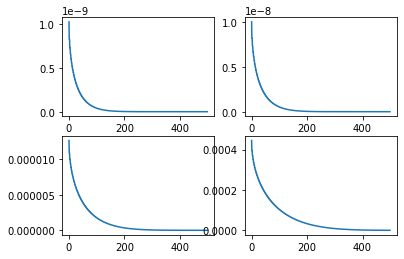

In [58]:
# 

fig, axs = plt.subplots(2, 2)
n=1000
hamm_distances = space_frac_to_hamm_dist(n, space_frac_rang)
r = 1
for ind, hamm_dist in enumerate(hamm_distances):
    circle_center_distances = np.arange(0,n//2,1).astype(int)
    res = expected_intersection_lune(n, circle_center_distances, hamm_dist, r)
    
    xind = ind//2
    yind = ind%2
    
    axs[xind, yind].plot(circle_center_distances, res,label="$d$="+str(hamm_dist))
    #axs[xind, yind].set_title()
    
for ax in axs.flat:
    ax.set(xlabel='$d_v$ between two vectors', 
           ylabel='Log $p$ in the Intersection')
    
for ax in axs.flat:
    #ax.label_outer()
    ax.legend()
    ax.set_yscale('log')
fig.tight_layout()
plt.gcf().savefig('figures/CircleInterActualVals_LogScale.png', dpi=250)
plt.show()

    